In [1340]:
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd 
from scipy.stats import ttest_rel
import numpy as np
from sklearn import metrics
from analysis import *
%matplotlib inline 

In [1341]:
FILE = "/Users/Student/Downloads/simple_analyses.html"

with open(FILE, 'r') as html_file:
    content = html_file.read()

# Get rid off prompts and source code
content = content.replace("div.input_area {","div.input_area {\n\tdisplay: none;")    
content = content.replace(".prompt {",".prompt {\n\tdisplay: none;")

f = open(FILE, 'w')
f.write(content)
f.close()

In [1342]:
# Get Sub Data

sub_data = mass_data('../../data')
full_data = mass_data('../../data')

In [1343]:
# Image Split

def img_split(image_list, cat = False):
    '''
    splits overlay image filenames into filenames of the original, single images
    
    input : list of image filenames
    output : list of image filenames OR two lists, separated by category
    
    '''
    
    split = [words for segments in image_list for words in segments.split('_')]
    a = [word+'.jpg' for word in split if word[-3:]!='jpg'] 
    b = [word for word in split if word[-3:]=='jpg']
    glom = a+b
    
    if cat == False:
        return(a+b)
    
    else:
        return(a,b)

In [1344]:
# Prop check - presented images

halfsies = []

for s in sub_data:

    cued_split = img_split(s['cued'])
    uncued_split = img_split(s['uncued'])

    u1 = set(s['images']).intersection(set(cued_split))
    u2 = set(s['images']).intersection(set(uncued_split))

    conglom = cued_split+uncued_split

    k = s['images']
    u3 = [x for x in k if x not in conglom]
    u4 = [x for x in k if x in conglom]

     
    for index,img in enumerate(s['images']):
        one = [words for segments in s['cued'] for words in segments.split('_')]

        
    if len(u1)+len(u2) == len(u3):
        halfsies.append(s)
        
#     else:
#         print('prev:')
#         print((len(u1)+len(u2))/320.0)
#         print(' ')
#         print('rand:')
#         print(len(u3)/320.0)
#         print(' ')


In [1345]:
sub_data = halfsies

In [1]:
for s in sub_data:
    for x in [s['cued'],s['uncued'],s['images']]:
        if not len(x) == len(set(x)):
            print('cue repeat, internal')

    for s in sub_data:
        if len([x for x in s['cued'] if x in s['uncued']]):
            print('Cue repeat, external')
    

NameError: name 'sub_data' is not defined

In [2]:
# function to reject outliers
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

    

In [1352]:
# Prep recall data

frames = []


for i,s in enumerate(sub_data): 
    rating_data = {'scores':[], 'cue':[], 'cat':[], 'time':[], 'skip':[]}

    cued_ratings1 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x in img_split(s['cued'],cat=True)[0]]
    cued_ratings2 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x in img_split(s['cued'],cat=True)[1]]
    
    uncued_ratings1 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x in img_split(s['uncued'],cat=True)[0]]
    uncued_ratings2 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x in img_split(s['uncued'],cat=True)[1]]
    
    cue_glom1 = cued_ratings1+cued_ratings2
    cue_glom2 = uncued_ratings1+uncued_ratings2
    
    rand_ratings1 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x[0:3]!='sun' and x not in img_split(s['cued'],cat=True)[0]+img_split(s['uncued'],cat=True)[0]]
    rand_ratings2 = [s['ratings'][ind] for ind,x in enumerate(s['images']) if x[0:3]=='sun' and x not in img_split(s['cued'],cat=True)[1]+img_split(s['uncued'],cat=True)[1]]
    
    #print(rand_ratings2)
    
    rand_glom = rand_ratings1+rand_ratings2
    
    all_ratings = cue_glom1 + cue_glom2 + rand_glom
    
    
    
    for x in all_ratings:
        if len(x)>1:
            score = x[1]
            skip = 0

        else:
            score = x[0]
            skip = 1
            
        rating_data['scores'].append(score[0])
        rating_data['skip'].append(skip)
        rating_data['time'].append(score[1])
            
    rating_data['cue'] = ['cued']*len(cue_glom1)+['uncued']*len(cue_glom2)+['rand']*len(rand_glom)
    rating_data['cat'] = ['place']*len(cued_ratings1)+['face']*len(cued_ratings2)+['place']*len(uncued_ratings1)+['face']*len(uncued_ratings2)+['place']*len(rand_ratings1)+['face']*len(rand_ratings2)

    rating_data = pd.DataFrame(rating_data) #, fill=True)        
    rating_data.fillna(value=np.nan, inplace=True)
    
    frames.append(pd.DataFrame(rating_data))
    
total = pd.concat(frames).reset_index(drop=True)

In [1321]:
# Prep ROC data

ROC = {'cued':[0],'uncued':[0], 'rand':[0]}

for typ in ['cued', 'uncued', 'rand']:
    nums = []
    
    for x in [1, 2, 3, 4]:
        if total[(total['scores']<=x) & (total['cue']==typ)].shape[0]>1:
            ROC[typ].append((total[(total['scores']<=x) & (total['cue']==typ)].shape[0])/float(total[total['cue']==typ].shape[0]))
        else:
            ROC[typ].append(0)
    ROC[typ].append(1)

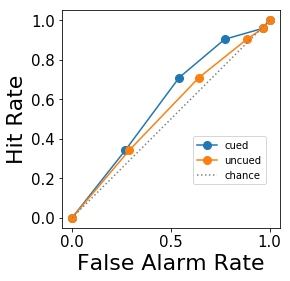

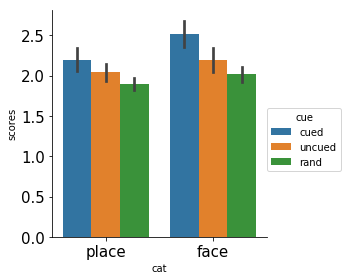

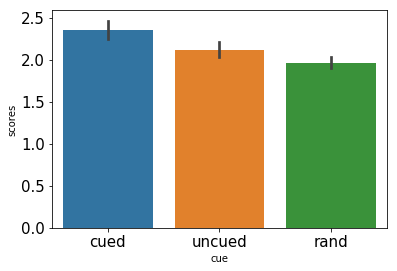

In [1333]:
# Plot All

plt.plot(ROC['cued'], ROC['rand'], '-o', label='cued', markersize=8)
plt.plot(ROC['uncued'], ROC['rand'], '-o', label='uncued', markersize=8)
plt.plot([0, 0.5, 1], [0, 0.5, 1], ':',color = 'gray', label='chance')
plt.axes().set_aspect('equal')
plt.legend(loc = (.6, .2))

labels = [1, 2, 3, 4]

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15


plt.ylabel('Hit Rate', size=22)
plt.xlabel('False Alarm Rate', size=22)
plt.show()

g = sns.factorplot(x="cat", y="scores",
                    hue="cue",
                    data=total, kind="bar",
                    size=4);
plt.show()

sns.barplot(x="cue", y="scores", data= total, ci=95)
plt.show()



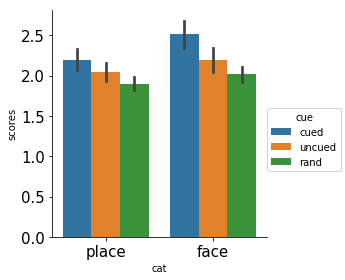

In [1331]:
g = sns.factorplot(x="cat", y="scores",
                    hue="cue",
                    data=total, kind="bar",
                    size=4);

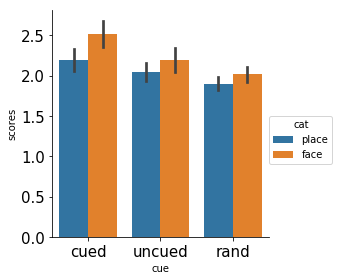

In [1305]:
g = sns.factorplot(x="cue", y="scores",
                    hue="cat",
                    data=total, kind="bar",
                    size=4);

# Analyze Ratings for ROC

In [1215]:
ROC = {'cued':[],'uncued':[], 'rand':[]}

for typ in ['cued', 'uncued', 'rand']:
    nums = []
    
    for x in [1, 2, 3, 4]:
        if total[(total['scores']<=x) & (total['cue']==typ)].shape[0]>1:
            ROC[typ].append((total[(total['scores']<=x) & (total['cue']==typ)].shape[0])/float(total[total['cue']==typ].shape[0]))
        else:
            ROC[typ].append(0)

# ROC Curve

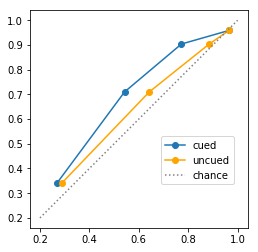

In [1216]:
plt.plot(ROC['cued'], ROC['rand'], '-o',label='cued')
plt.plot(ROC['uncued'], ROC['rand'], '-o', color = 'orange', label='uncued')
plt.plot([0.2, 0.5, 1], [0.2, 0.5, 1], ':',color = 'gray', label='chance')
plt.axes().set_aspect('equal')
plt.legend(loc = (.6, .2))
plt.show()